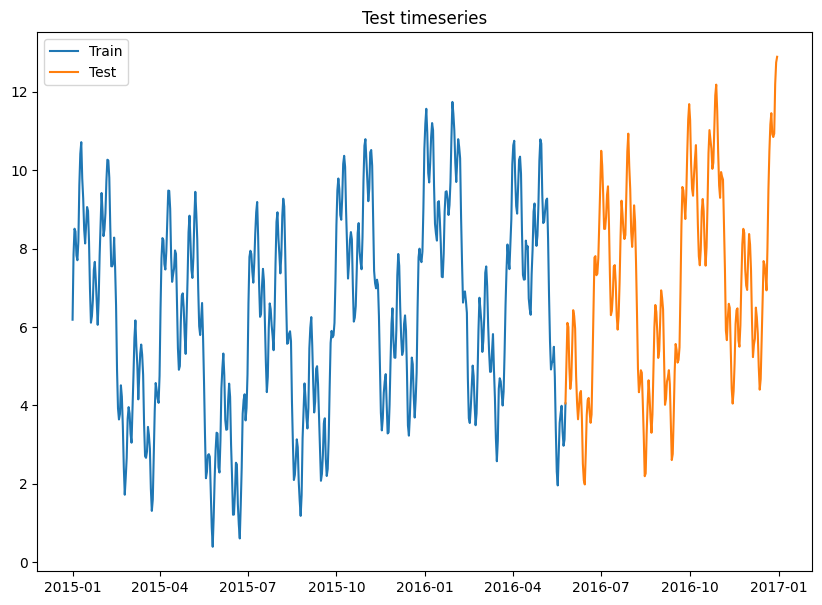

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
date = np.arange(datetime(2015, 1, 1), 
                 datetime(2016, 12, 31), 
                 timedelta(days=1)).astype(datetime)
days = date.shape[0]

np.random.seed(42)
noise = np.random.rand(days)*0.5 + 1

base = np.linspace(0, 2*np.pi, days) 
weekly = np.sin(base*days/7)
monthly = 2*np.sin(base*days/30)
seasonly = 2.5*np.sin(base*days/90) + 0.5
biyearly = np.cos(base*2)
ramp = np.linspace(3.5, 6, days)

values = biyearly + seasonly + monthly + weekly + noise + ramp

plt.figure(figsize=(10,7))
plt.plot(date[:int(days*0.7)+1], values[:int(days*0.7)+1], label = 'Train')
plt.plot(date[int(days*0.7):], values[int(days*0.7):], label = 'Test')
plt.legend()
plt.title('Test timeseries')
plt.show()

Epoch 100/1500 - Train Loss: 0.0649 - Val Loss: 0.0966
Epoch 200/1500 - Train Loss: 0.0459 - Val Loss: 0.1162
Epoch 300/1500 - Train Loss: 0.0245 - Val Loss: 0.1115
Epoch 400/1500 - Train Loss: 0.0353 - Val Loss: 0.1494
Epoch 500/1500 - Train Loss: 0.0107 - Val Loss: 0.1739
Epoch 600/1500 - Train Loss: 0.0082 - Val Loss: 0.1892
Epoch 700/1500 - Train Loss: 0.0076 - Val Loss: 0.1824
Epoch 800/1500 - Train Loss: 0.0130 - Val Loss: 0.1920
Epoch 900/1500 - Train Loss: 0.0025 - Val Loss: 0.2009
Epoch 1000/1500 - Train Loss: 0.0009 - Val Loss: 0.1948
Epoch 1100/1500 - Train Loss: 0.0006 - Val Loss: 0.2059
Epoch 1200/1500 - Train Loss: 0.0003 - Val Loss: 0.1986
Epoch 1300/1500 - Train Loss: 0.0009 - Val Loss: 0.1765
Epoch 1400/1500 - Train Loss: 0.0003 - Val Loss: 0.1925
Epoch 1500/1500 - Train Loss: 0.0129 - Val Loss: 0.2017

Best model found at epoch 206 with validation loss: 0.0788


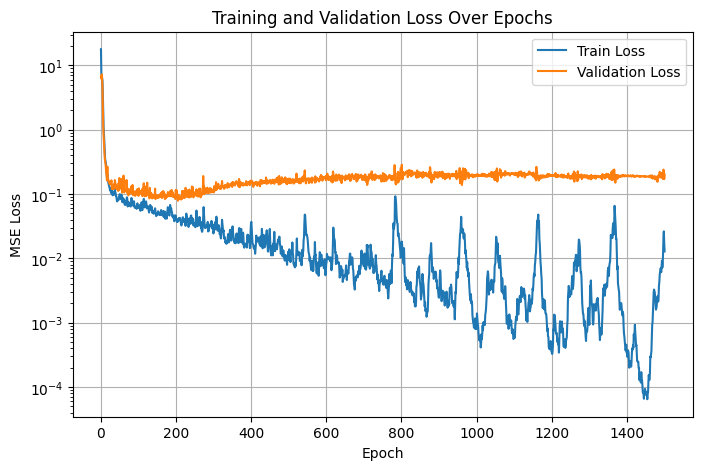

MAPE = 41.03018976800156


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

def percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.abs((y_true - y_pred) / y_true) * 100


def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ---------------------------
# Data Generation
# ---------------------------
date = np.arange(datetime(2015, 1, 1), 
                 datetime(2016, 12, 31), 
                 timedelta(days=1)).astype(datetime)
days = date.shape[0]

np.random.seed(42)
noise = np.random.rand(days) * 0.5 + 1

base = np.linspace(0, 2 * np.pi, days)
weekly = np.sin(base * days / 7)
monthly = 2 * np.sin(base * days / 30)
seasonly = 2.5 * np.sin(base * days / 90) + 0.5
biyearly = np.cos(base * 2)
ramp = np.linspace(3.5, 6, days)

values = biyearly + seasonly + monthly + weekly + noise + ramp

# ---------------------------
# Train/Validation/Test Split
# ---------------------------
# Test: last 30% of the days
test_split = int(days * 0.7)
train_val_data = values[:test_split]
test_data = values[test_split:]

# Within the first 70%, use 80% for training and 20% for validation
val_split = int(len(train_val_data) * 0.8)
train_data = train_val_data[:val_split]
val_data = train_val_data[val_split:]

# ---------------------------
# Prepare PyTorch Dataset using a Sliding Window Approach
# ---------------------------
window_size = 30

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size]
        # Reshape x to (window_size, 1)
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32)
        
train_dataset = TimeSeriesDataset(train_data, window_size)
val_dataset = TimeSeriesDataset(val_data, window_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ---------------------------
# Define the LSTM Model
# ---------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size = 5, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: (batch, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output at the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(hidden_size=50).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ---------------------------
# Training Loop with Validation and Best Model Selection
# ---------------------------
epochs = 1_500
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0

for epoch in range(epochs):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * x_batch.size(0)
        
    epoch_train_loss /= len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)
    
    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            epoch_val_loss += loss.item() * x_batch.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    
    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        best_epoch = epoch + 1  # Store the epoch (1-based index)
        
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

# Load the best model state for forecasting
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\nBest model found at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")

# ---------------------------
# Plot Training and Validation Loss Over Epochs
# ---------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_history, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Forecasting on Test Data (Recursive Multi-step Forecast)
# ---------------------------
model.eval()
predictions = []
# Use the last window from the entire train+validation data as the starting point
last_window = train_val_data[-window_size:]
window = last_window.copy()

for i in range(len(test_data)):
    # Prepare input: shape (1, window_size, 1)
    input_seq = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    with torch.no_grad():
        pred = model(input_seq).item()
    predictions.append(pred)
    # Update the window: slide by one, adding the new prediction
    window = np.append(window[1:], pred)

MAPE = mape(test_data, predictions)
print(f'MAPE = {MAPE}')

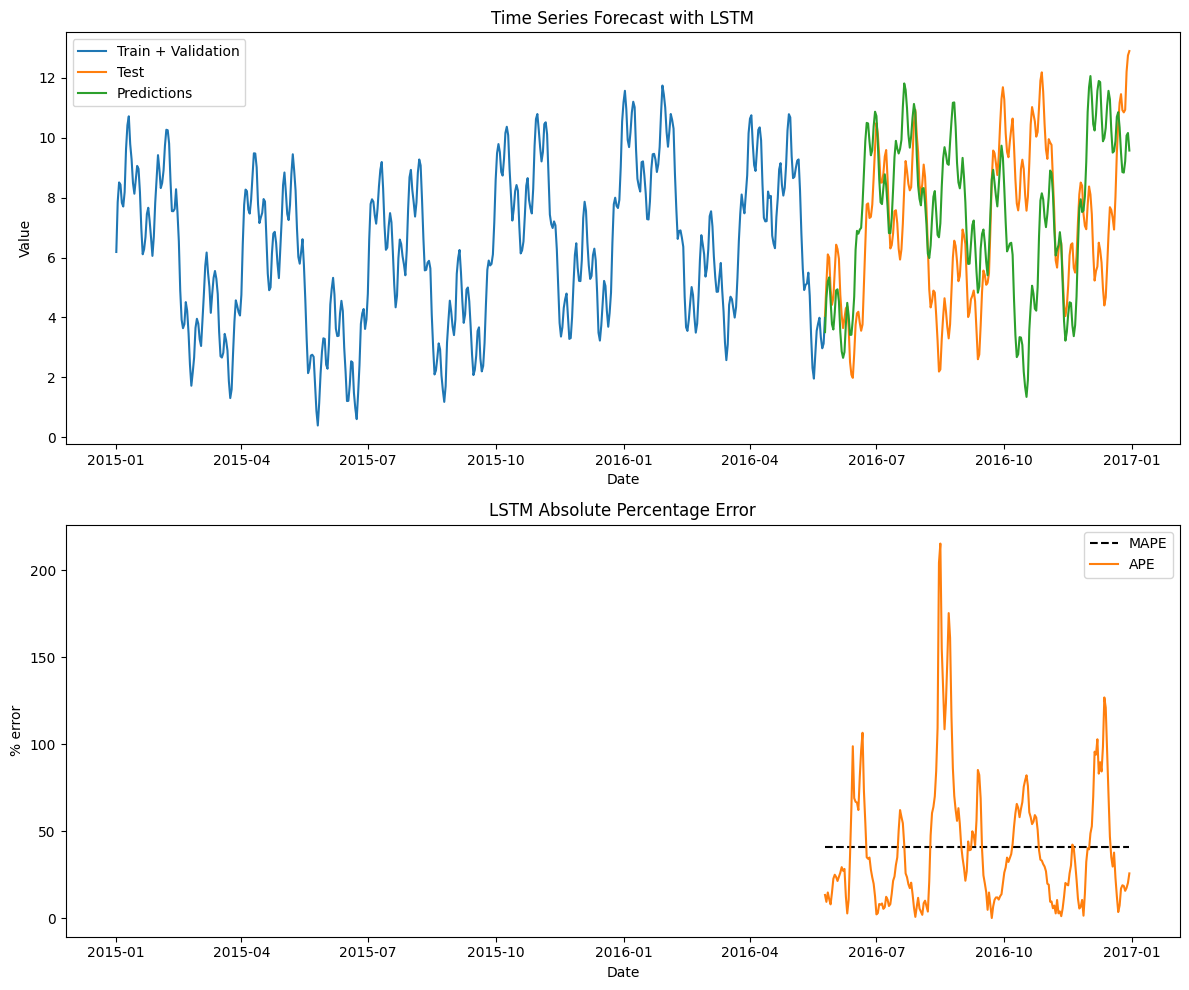

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))

# ---------------------------
# Plot the Forecast Results
# ---------------------------
ax1[0].plot(date[:test_split+1], values[:test_split+1], label='Train + Validation')
ax1[0].plot(date[test_split:], test_data, label='Test')
ax1[0].plot(date[test_split:], predictions, label='Predictions')
ax1[0].set_xlabel("Date")
ax1[0].set_ylabel("Value")
ax1[0].set_title("Time Series Forecast with LSTM")
ax1[0].legend()

# ---------------------------
# Plot the Forecast Error
# ---------------------------
ax1[1].plot(date, values, alpha=0)
ax1[1].plot(date[test_split:], MAPE * np.ones(date[test_split:].shape[0]), linestyle='dashed', color='k', label='MAPE')
ax1[1].plot(date[test_split:], percentage_error(test_data, predictions), label='APE')
ax1[1].set_xlabel("Date")
ax1[1].set_ylabel("% error")
ax1[1].set_title("LSTM Absolute Percentage Error")
ax1[1].legend()

plt.tight_layout()
plt.show()
